In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

PATH = '../'
RND_SEED = 44

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

Wall time: 2.55 s


<img src='desc.png'></img>

In [8]:
print(train.shape)
train.head()

(649912, 15)


,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [9]:
print(test.shape)
test.head()

(284071, 9)


,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [72]:
# Скорее всего взяли 300 рандомных спутников из трейна и поместили в тест, может быть важно для валидации

ltr, lte = len(train['sat_id'].unique()), len(test['sat_id'].unique())
print(f'Unique satellites in train {ltr}')
print(f'Unique satellites in train {lte}')

Unique satellites in train 600
Unique satellites in train 300


## Observations EDA

### Num observations for each satellite

Min observations: 94 for satellite 252, Max observations: 6320  for satellite 372
Mean: 1083.1866666666667




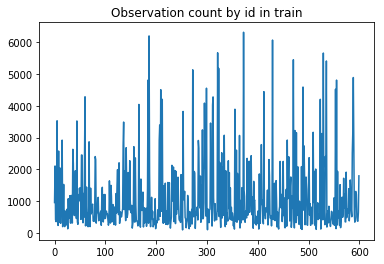

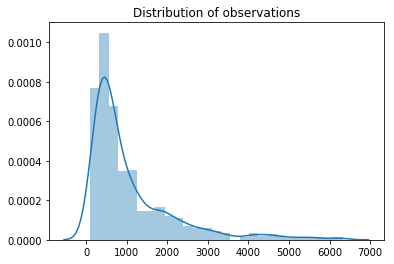

In [68]:
ids, obs = train.groupby('sat_id').count().iloc[:, 0].index, train.groupby('sat_id').count().iloc[:, 0].values
print(f'Min observations: {min(obs)} for satellite {ids[np.argwhere(obs == min(obs))][0][0]}, Max observations: {max(obs)}  for satellite {ids[np.argwhere(obs == max(obs))][0][0]}')
print(f'Mean: {np.mean(obs)}\n\n')
plt.title('Observation count by id in train');
plt.plot(ids, obs);
plt.show();

plt.title('Distribution of observations')
sns.distplot(obs)
plt.show()

Min observations: 84 for satellite 252, Max observations: 5707  for satellite 372
Mean: 946.9033333333333




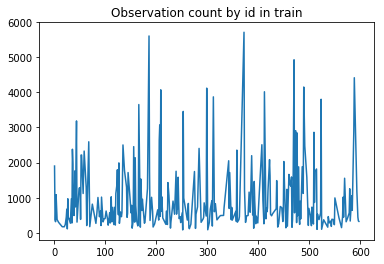

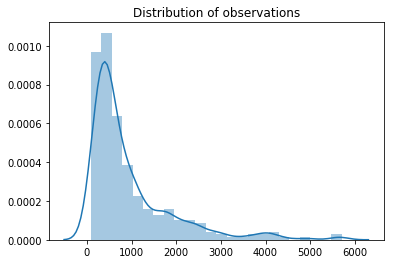

In [69]:
ids, obs = test.groupby('sat_id').count().iloc[:, 0].index, test.groupby('sat_id').count().iloc[:, 0].values
print(f'Min observations: {min(obs)} for satellite {ids[np.argwhere(obs == min(obs))][0][0]}, Max observations: {max(obs)}  for satellite {ids[np.argwhere(obs == max(obs))][0][0]}')
print(f'Mean: {np.mean(obs)}\n\n')
plt.title('Observation count by id in train');
plt.plot(ids, obs);
plt.show();

plt.title('Distribution of observations')
sns.distplot(obs)
plt.show()

### Delta observations for common satellites in train & test

In [91]:
trainTestSatellites = train['sat_id'].unique()[[True if sat_id in test['sat_id'].unique() else False for sat_id in train['sat_id'].unique()]]
trainTestData = train.loc[[True if sat_id in trainTestSatellites else False for sat_id in train['sat_id'].values], :]

In [100]:
deltaObs = np.abs(trainTestData.groupby('sat_id').count().iloc[:,0] - test.groupby('sat_id').count().iloc[:,0])
print(f'Mean delta between train and test: {np.mean(deltaObs)}')
print(f'Max delta between train and test: {np.max(deltaObs)}')
print(f'Min delta between train and test: {np.min(deltaObs)}')

Mean delta between train and test: 103.70666666666666
Max delta between train and test: 613
Min delta between train and test: 10


### Time gap between observations for one satellite

Для разных спутников дельта разная, но для одного и того же спутника в трейне и тесте дельта одна и та же

In [132]:
ID = np.random.choice(train['sat_id'].unique(), 1)[0]
dataTrain = train[train['sat_id'] == ID]
deltaTsTrain = []
for idx in range(1, dataTrain.shape[0]):
    delta = pd.to_datetime(dataTrain['epoch'].iloc[idx]) - pd.to_datetime(dataTrain['epoch'].iloc[idx-1])
    deltaTsTrain.append(delta)
print(f'Delta between 2 observations for satellite {ID} in Train is {deltaTsTrain[0]}')

if ID in test['sat_id'].unique():
    dataTest = test[test['sat_id'] == ID]
    deltaTsTest = []
    for idx in range(1, dataTest.shape[0]):
        delta = pd.to_datetime(dataTest['epoch'].iloc[idx]) - pd.to_datetime(dataTest['epoch'].iloc[idx-1])
        deltaTsTest.append(delta)
    print(f'Delta between 2 observations for satellite {ID} in Test is {deltaTsTest[0]}')
else:
    print('ID not present')

Delta between 2 observations for satellite 113 in Train is 0 days 02:08:42.619000
Delta between 2 observations for satellite 113 in Test is 0 days 02:08:42.619000


Зависит ли количество данных для спутника от дельты?

In [136]:
results = []
for ID in tqdm(train['sat_id'].unique()): 
    dataTrain = train[train['sat_id'] == ID]
    deltaTsTrain = []
    for idx in range(1, dataTrain.shape[0]):
        delta = pd.to_datetime(dataTrain['epoch'].iloc[idx]) - pd.to_datetime(dataTrain['epoch'].iloc[idx-1])
        deltaTsTrain.append(delta)
    results.append([ID, deltaTsTrain[0], len(deltaTsTrain)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 600/600 [02:47<00:00,  3.43it/s]


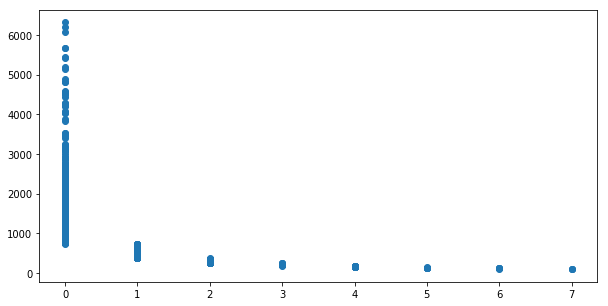

In [186]:
hours = []
for res in results:
    hours.append(int(str(res[1]).split(':')[0].split(' ')[-1]))
plt.figure(figsize = (10,5))
plt.scatter(hours, pd.DataFrame(results).iloc[:, -1].values)
plt.show()

In [191]:
for val in np.unique(hours):
    print(f'Mean observations: {np.mean(pd.DataFrame(results).iloc[:, -1].values[hours == val])} Gap: {val} hours')

Mean observations: 1883.4595588235295 Gap: 0 hours
Mean observations: 530.6958762886597 Gap: 1 hours
Mean observations: 311.05333333333334 Gap: 2 hours
Mean observations: 219.6551724137931 Gap: 3 hours
Mean observations: 168.2 Gap: 4 hours
Mean observations: 134.85714285714286 Gap: 5 hours
Mean observations: 118.0 Gap: 6 hours
Mean observations: 100.0 Gap: 7 hours


Делаем вывод, что зависит. Чем больше наблюдений для спутника, тем длиннее геп между снимками.
! Стоит помнить что я тут не учитываю дни, возможно у некоторых спутников геп больше дня.

Все это я проверяю в надежде что от гепа и кол-ва наблюдений как-то зависит траектория полета (орбита там или еще что)

In [192]:
gc.collect()

13623

## Satellite movement EDA

Визуализируем движение одного спутника по орбите

In [242]:
# ID - 133, 575
# Является примером когда кластер как будто смещается на 1 на каждом прохождение по всей орбите, 
# за счет этого дельта очень интересно возрастает

In [557]:
SAT_ID = ID = np.random.choice(train['sat_id'].unique(), 1)[0]
SAT_ID = ID = 166

data = train[train['sat_id'] == ID].reset_index(drop = True)
satTrain = train[train['sat_id'] == SAT_ID]
satTest = test[test['sat_id'] == SAT_ID]

print(f'ID: {SAT_ID}, Total observations: {satTrain.shape[0]}; In test {satTest.shape[0]}')

ID: 166, Total observations: 4046; In test 3650


In [549]:
# Зависимость координат и симулированных координат от времени

x,y,z = satTrain.loc[:, 'x'].values, satTrain.loc[:, 'y'].values, satTrain.loc[:, 'z'].values
xSim,ySim,zSim = satTrain.loc[:, 'x_sim'].values, satTrain.loc[:, 'y_sim'].values, satTrain.loc[:, 'z_sim'].values

xTestSim, yTestSim, zTestSim = satTest.loc[:, 'x_sim'].values, satTest.loc[:, 'y_sim'].values, satTest.loc[:, 'z_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        #color='rgb(127, 127, 127)',
                        color = np.arange(satTrain.shape[0]),
                        colorscale = 'Viridis',
                        showscale = True,
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')

fig3 = go.Scatter3d(x=xTestSim, 
                    y=yTestSim, 
                    z=zTestSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(255, 87, 123, 0.05)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'SimulatedTest')
fig = go.Figure(data = [fig1, fig2, fig3])
fig.show()

In [254]:
# Зависимость скорости и симулированной скорости от времени

x,y,z = satTrain.loc[:, 'Vx'].values, satTrain.loc[:, 'Vy'].values, satTrain.loc[:, 'Vz'].values
xSim,ySim,zSim = satTrain.loc[:, 'Vx_sim'].values, satTrain.loc[:, 'Vy_sim'].values, satTrain.loc[:, 'Vz_sim'].values

xTestSim, yTestSim, zTestSim = satTest.loc[:, 'Vx_sim'].values, satTest.loc[:, 'Vy_sim'].values, satTest.loc[:, 'Vz_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        #color='rgb(127, 127, 127)',
                        color = np.arange(satTrain.shape[0]),
                        colorscale = 'Viridis',
                        showscale = True,
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')

fig3 = go.Scatter3d(x=xTestSim, 
                    y=yTestSim, 
                    z=zTestSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(255, 87, 123, 0.05)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'SimulatedTest')
fig = go.Figure(data = [fig1, fig2, fig3])
fig.show()

In [351]:
# Анимированное движение спутника

frames = []
x,y,z = [], [], []
framesTot = 100
for point in range(0, data.shape[0])[:framesTot]:
    if point == 0:
        x,y,z = [data.loc[point, 'x']], [data.loc[point, 'y']], [data.loc[point, 'z']]
    else:
        x.append(data.loc[point, 'x']), y.append(data.loc[point, 'y']), z.append(data.loc[point, 'z'])
        frames.append(go.Frame(data=[go.Scatter3d(x=x, y=y, z=z)]))
    
fig = go.Figure(
    data=[go.Scatter3d(x = [x[0]], y=[y[0]], z = [z[0]],
                      marker=dict(
                        #color='rgb(127, 127, 127)',
                        #color = np.arange(len(x)),
                        color = labels[:framesTot],
                        colorscale = 'Viridis',
                        showscale = True,
                        size=5, 
                        symbol='circle', 
                        opacity=0.9),
                   name = 'Real')],
    layout=go.Layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    ),
    frames=frames
)


fig.update_layout(scene=dict(
    xaxis=dict(nticks=4, range=[-200000, 200000],),
    yaxis=dict(nticks=4, range=[-200000, 200000],),
    zaxis=dict(nticks=4, range=[-200000, 200000],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10),
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None])])]
)
fig.show()

Советую потыкаться в графики выше с разными айдишниками, очень познавательно

In [558]:
# Разобъем на кластеры по x_sim, y_sim, z_sim, кластеров всегда будет 24 (империческое наблюдение так сказать)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
model = KMeans(n_clusters=24, tol = 1e-3, algorithm = 'elkan', random_state=RND_SEED)
#model = DBSCAN(eps = 1000)
labels = model.fit_predict(satTrain[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']])
print('Num unique labels: ', len(np.unique(labels)))

Num unique labels:  24


In [559]:
fig1 = go.Scatter3d(x=xSim,
                    y=ySim,
                    z=zSim,
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=labels,  # set color equal to a variable
                        colorscale='Viridis',  # one of plotly colorscales
                        showscale=True
                    ),
                    name='Real')
fig = go.Figure(data = [fig1])
fig.show()

In [506]:
# labels = np.array(list(np.arange(0,24)) * (int(satTrain.shape[0] / 24) + 1))[:satTrain.shape[0]]
# testLabels = np.array(list(np.arange(0,24)) * (int(satTest.shape[0] / 24) + 1))[:satTest.shape[0]]

In [560]:
# Отобразим все x,y,z, xsim, ysim, zsim, относящиеся к одному кластеру
CLUSTER = 1
CLUSTER2 = 1
CLUSTER3 = 1
CLUSTER4 = 1
clusterDataTrain = satTrain[(labels == CLUSTER) | (labels == CLUSTER2) | (labels == CLUSTER3) | (labels == CLUSTER4)]
 
testLabels = model.predict(satTest[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']])
clusterDataTest = satTest[(testLabels == CLUSTER)| (testLabels == CLUSTER2) | (testLabels == CLUSTER3) | (testLabels == CLUSTER4)]


# Зависимость координат и симулированных координат от времени

x,y,z = clusterDataTrain.loc[:, 'x'].values, clusterDataTrain.loc[:, 'y'].values, clusterDataTrain.loc[:, 'z'].values
xSim,ySim,zSim = clusterDataTrain.loc[:, 'x_sim'].values, clusterDataTrain.loc[:, 'y_sim'].values, clusterDataTrain.loc[:, 'z_sim'].values

xTestSim, yTestSim, zTestSim = clusterDataTest.loc[:, 'x_sim'].values, clusterDataTest.loc[:, 'y_sim'].values, clusterDataTest.loc[:, 'z_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        #color='rgb(127, 127, 127)',
                        color = np.arange(clusterDataTrain.shape[0]),
                        colorscale = 'Viridis',
                        showscale = True,
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')

fig3 = go.Scatter3d(x=xTestSim, 
                    y=yTestSim, 
                    z=zTestSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(255, 87, 123, 0.05)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'SimulatedTest')
fig = go.Figure(data = [fig1, fig2, fig3])
fig.show()

## Features EDA

Поиграемся с нормами

Норма вектора реальных координат, трейн:


In [540]:
print(f'ID: {ID}, Total observations: {data.shape[0]}')

ID: 593, Total observations: 1307


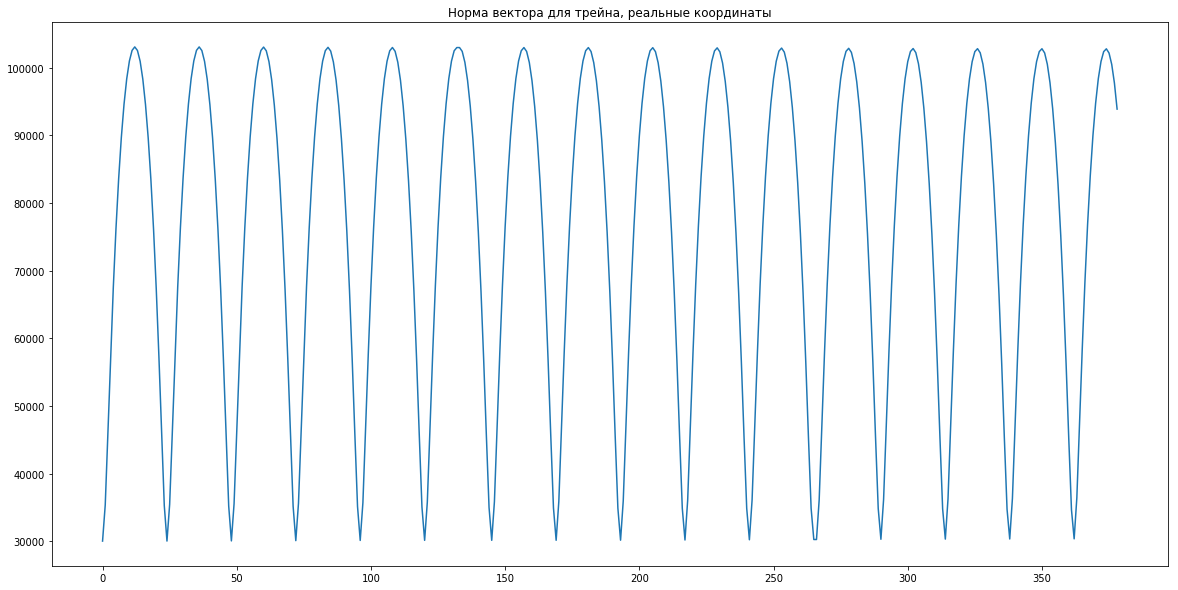

In [440]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма вектора для трейна, реальные координаты')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))

Норма вектора симулированных координат, трейн и тест

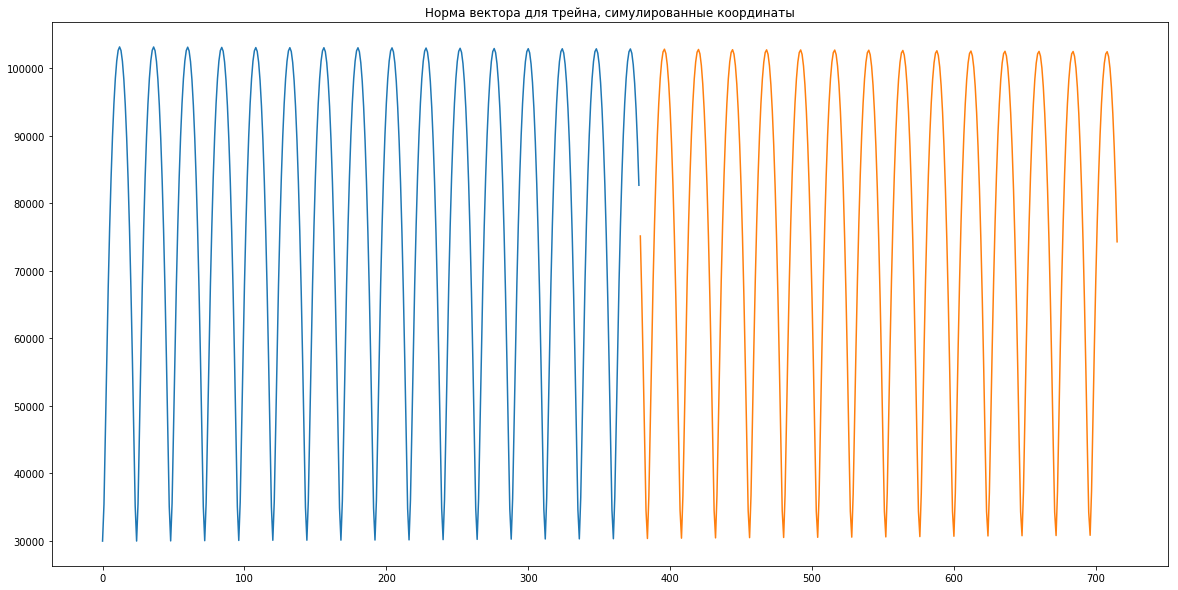

In [439]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
satDataTest = test[test['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
plt.figure(figsize = (20,10))
plt.title('Норма вектора для трейна, симулированные координаты')
plt.plot(np.arange(len(satDataTrain)), np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.arange(len(satDataTrain), len(satDataTrain) + len(satDataTest)), np.linalg.norm(satDataTest, axis = 1))

Норма вектора скорости, трейн:

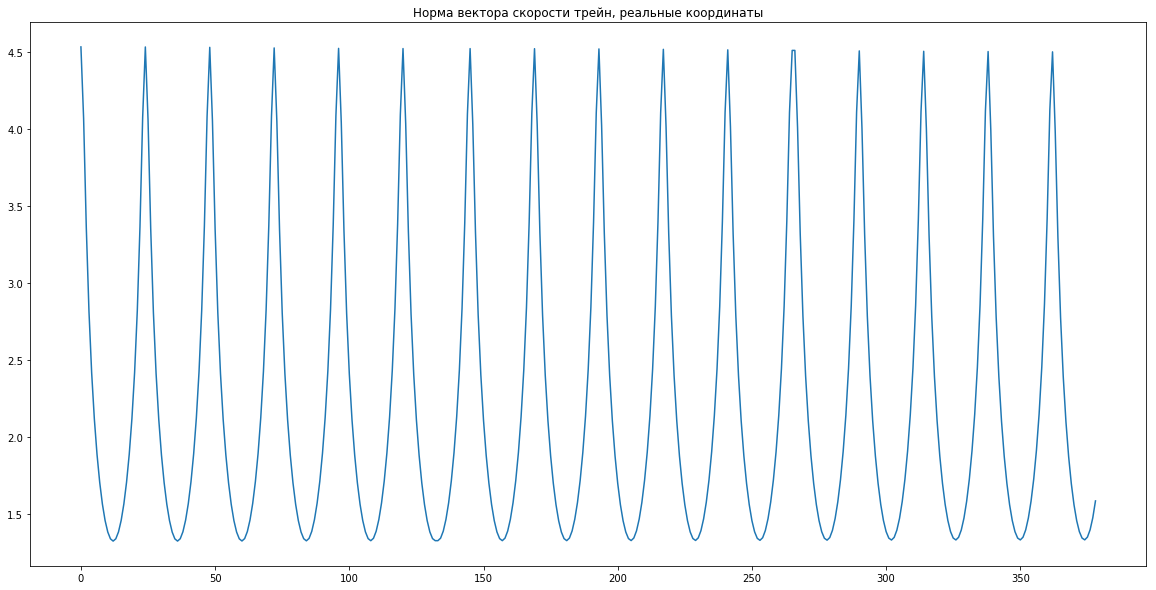

In [438]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['Vx', 'Vy', 'Vz']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма вектора скорости трейн, реальные координаты')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))

Норма вектора скорости симулированной, трейн и тест

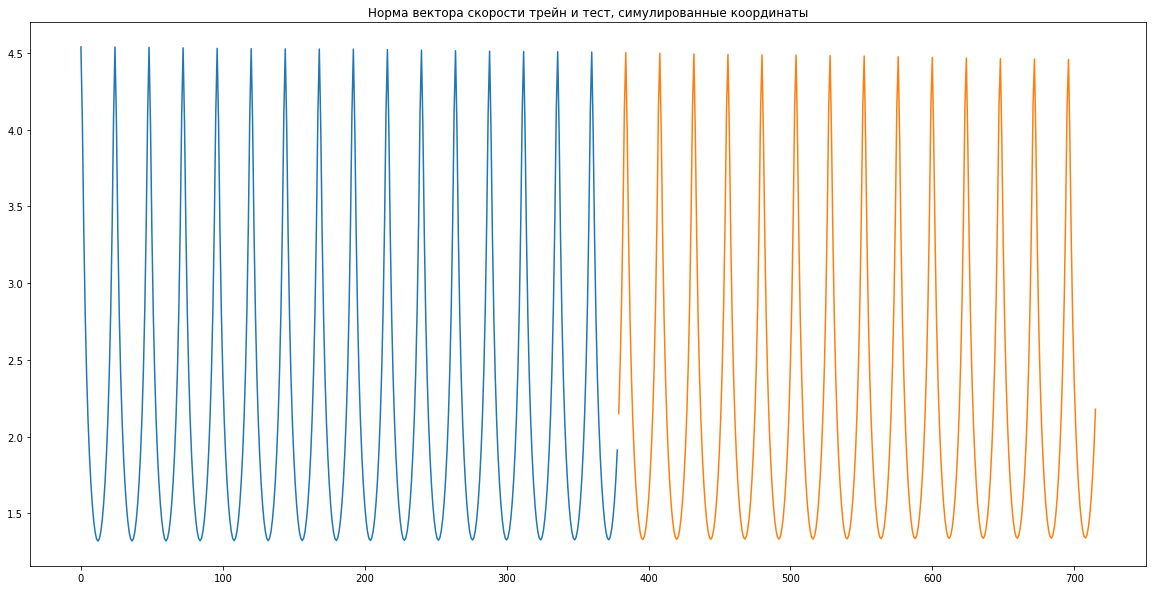

In [437]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['Vx_sim', 'Vy_sim', 'Vz_sim']]
satDataTest = test[test['sat_id'] == SAT_ID].loc[:, ['Vx_sim', 'Vy_sim', 'Vz_sim']]
plt.figure(figsize = (20,10))
plt.title('Норма вектора скорости трейн и тест, симулированные координаты')
plt.plot(np.arange(len(satDataTrain)), np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.arange(len(satDataTrain), len(satDataTrain) + len(satDataTest)), np.linalg.norm(satDataTest, axis = 1))

Норма симулированного вектора координат против реальных

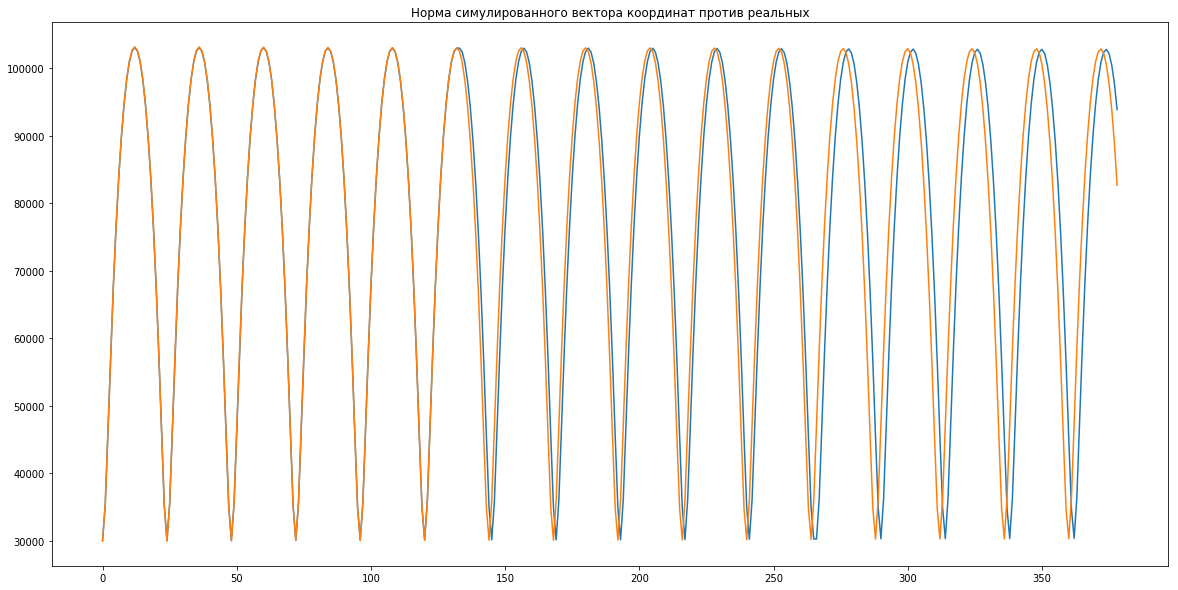

In [441]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма симулированного вектора координат против реальных')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.linalg.norm(satDataTrainSim, axis = 1))

Норма дельты между реальностью и симуляцией

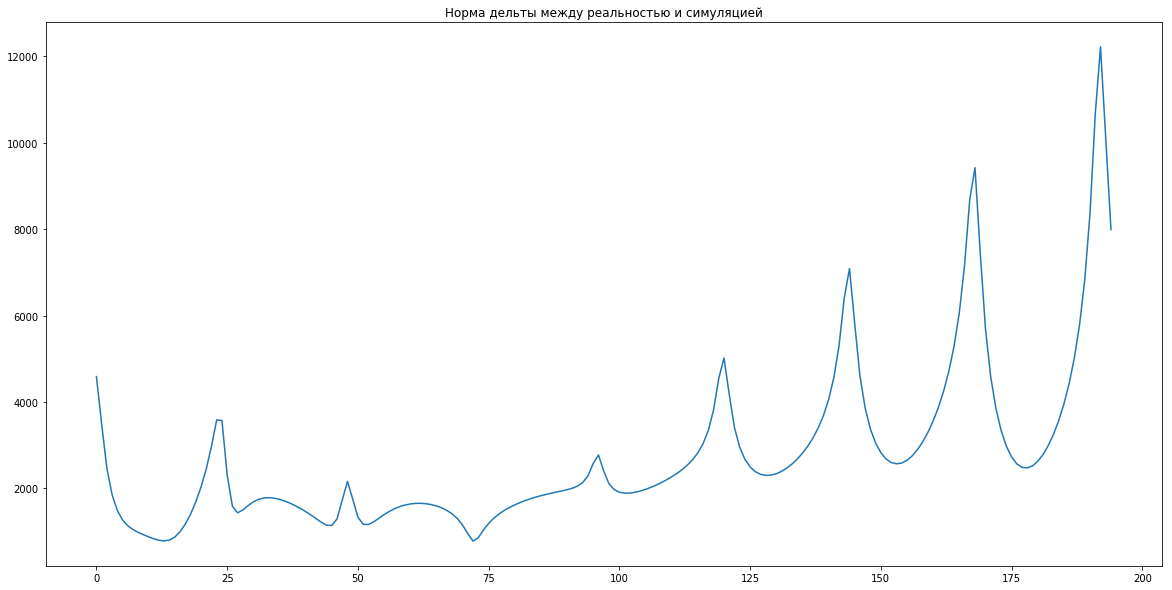

In [573]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))

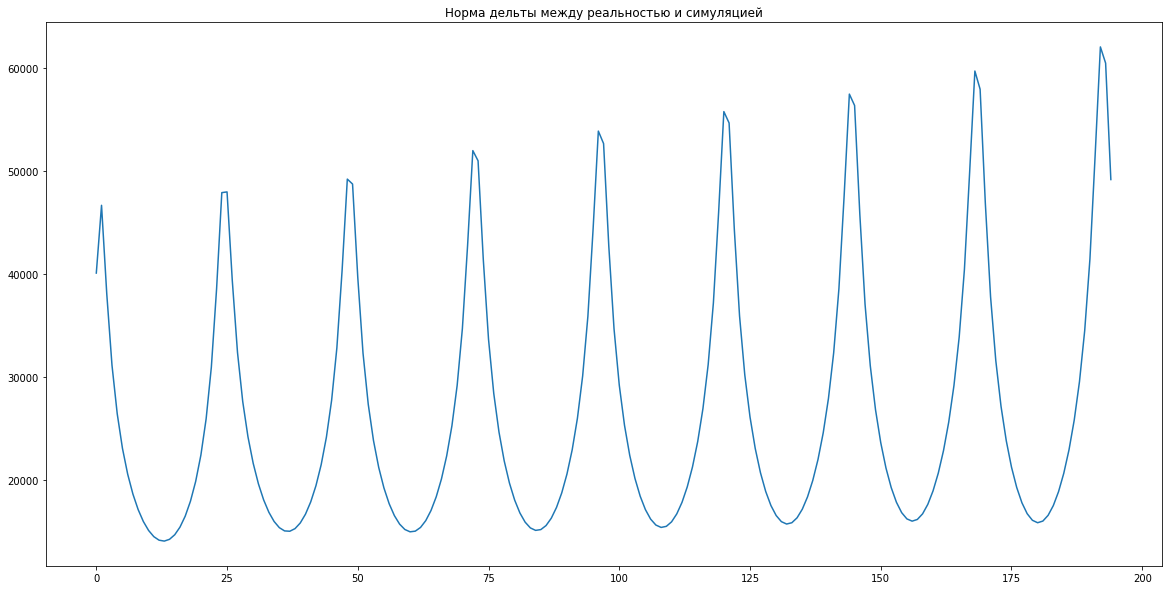

In [575]:
# ОЙЙЙ, Здравствуйте! Получается shift идет на один кластер назад за счет смещения скорости, 
# полагаю что смещение постоянное (можно найти как часто смещается)
SAT_ID = ID 
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']].shift(1).fillna(0)
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))

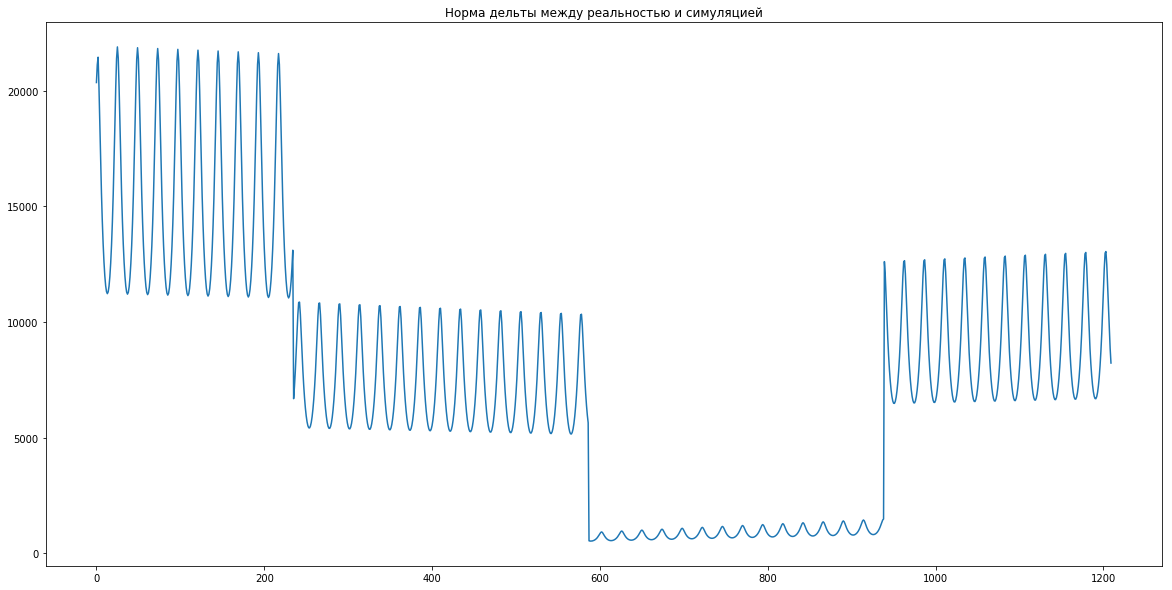

In [555]:
# ОЙЙЙ, Здравствуйте! А тут уже на 2 кластера назад в последнем скачке
# полагаю что смещение постоянное (можно найти как часто смещается)
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']].shift(2).fillna(0)
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))

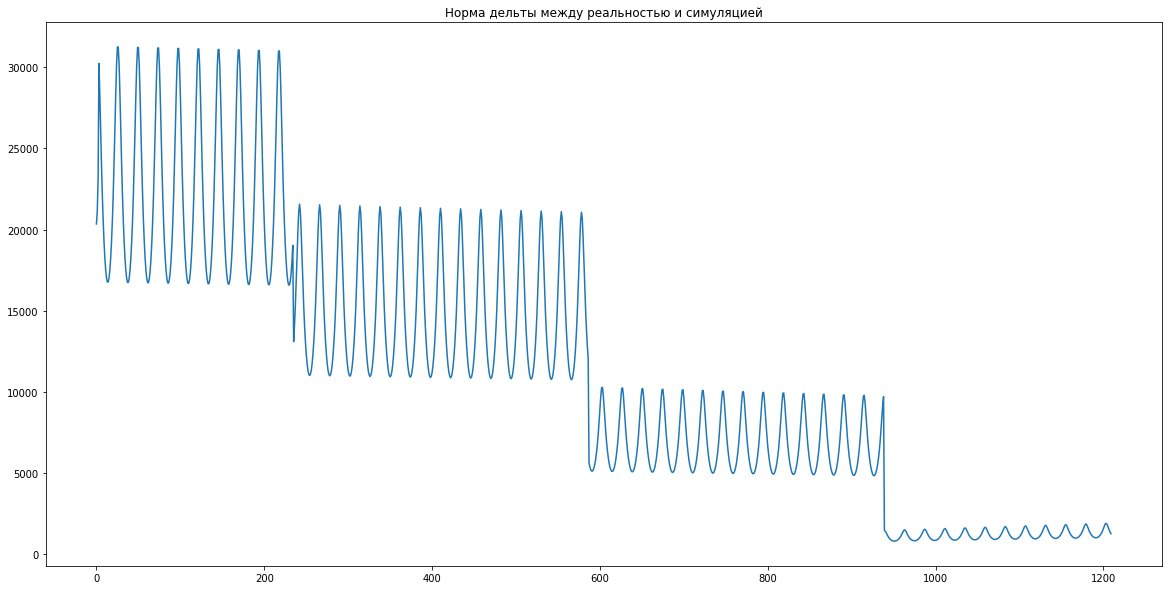

In [556]:
# ОЙЙЙ, Здравствуйте! А тут уже на 3 кластера назад в последнем скачке
# полагаю что смещение постоянное (можно найти как часто смещается)
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']].shift(3).fillna(0)
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))

Посмотрим сколько в трейне наблюдений, которые нужно шифтить, а сколько адекватных

In [546]:
from sklearn.linear_model import LinearRegression
modelPart = LinearRegression()
modelFull = LinearRegression()
for sat_id in train['sat_id'].unique():
    if sat_id == ID:
        data = train[train['sat_id'] == sat_id]
        satDataTrain = data.loc[:, ['x', 'y', 'z']]
        satDataTrainSim = data.loc[:, ['x_sim', 'y_sim', 'z_sim']]
        norm = np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1)
        x = np.arange(len(norm))[:int(len(norm) * 0.05)].reshape(-1,1)
        y = norm[:int(len(norm) * 0.05)]
        coef1 = (y[-1] - y[0]) / (x[-1] - x[0])
        x = np.arange(len(norm)).reshape(-1,1)
        y = norm
        coef2 = (y[-1] - y[0]) / (x[-1] - x[0]) 
        print(f'Coef Part: {coef1}, Coef Full: {coef2}')

Coef Part: [0.91687779], Coef Full: [0.85921274]


In [564]:
from sklearn.linear_model import LinearRegression
modelPart = LinearRegression()
modelFull = LinearRegression()

shiftSats, linearSats = [], []
for sat_id in train['sat_id'].unique():
    data = train[train['sat_id'] == sat_id]
    satDataTrain = data.loc[:, ['x', 'y', 'z']]
    satDataTrainSim = data.loc[:, ['x_sim', 'y_sim', 'z_sim']]
    norm = np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1)
    x = np.arange(len(norm))[:int(len(norm) * 0.05)].reshape(-1,1)
    y = norm[:int(len(norm) * 0.05)]
    coef1 = (y[-1] - y[0]) / (x[-1] - x[0])
    x = np.arange(len(norm)).reshape(-1,1)
    y = norm
    coef2 = (y[-1] - y[0]) / (x[-1] - x[0]) 
#     print(sat_id, coef1, coef2)
    if np.abs(coef1 - coef2) < 2:
        linearSats.append(sat_id)
    else:
        shiftSats.append(sat_id)
print(f'Total linear sats {len(linearSats)}\nTotal shift sats {len(shiftSats)}')

Total linear sats 176
Total shift sats 424


In [ ]:
linearSat, shiftedSat, shiftedStrangeSat, otherSat = [], [], [], []

In [577]:
from IPython.display import clear_output
for sat_id in test['sat_id'].unique():
    if sat_id >= 435:
        satDataTrain = train[train['sat_id'] == sat_id].loc[:, ['x', 'y', 'z']]
        satDataTrainSim = train[train['sat_id'] == sat_id].loc[:, ['x_sim', 'y_sim', 'z_sim']]
        plt.figure(figsize = (10,5))
        plt.title(f'Спутник {sat_id}')
        plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))
        plt.show()
        print('\n')
        print('1 - Linear, 2 - Shifted, 3 - Shifted Strange, 4 - Other')
        num = int(input())
        if num == 1:
            linearSat.append(sat_id)
        elif num == 2:
            shiftedSat.append(sat_id)
        elif num == 3:
            shiftedStrangeSat.append(sat_id)
        elif num == 4:
            otherSat.append(sat_id)
        clear_output()

In [580]:
shiftedSat

[1,
 2,
 3,
 4,
 25,
 27,
 32,
 38,
 41,
 45,
 59,
 63,
 84,
 86,
 92,
 98,
 100,
 101,
 109,
 112,
 118,
 123,
 124,
 125,
 126,
 133,
 135,
 149,
 151,
 155,
 173,
 177,
 186,
 188,
 195,
 208,
 213,
 223,
 230,
 236,
 241,
 242,
 243,
 247,
 248,
 251,
 264,
 270,
 278,
 348,
 363,
 375,
 380,
 382,
 385,
 390,
 392,
 407,
 409,
 415,
 416,
 418,
 422,
 437,
 440,
 450,
 468,
 476,
 477,
 480,
 483,
 495,
 502,
 505,
 508,
 536,
 539,
 542,
 549,
 558,
 565,
 575,
 580,
 595,
 596,
 597]